# Stimare Q function ottimale
## 1. Quanto tempo ci mette per convergere a Q*, al variare di tau
## 2. Distanza tra Q* e Q_t 
## 3. distanza tra Q_0 e Q_0 appresa tramite i valori di tau
## 4. cercare di integrare i bound trovati
## 5. Test della policy appresa con tau sull'mdp originale
## 6. Performance durante l'apprendimento per verificare la convergenza
## 7. Approfondire cosa succede per 0 < tau < 0.1 

In [1]:
import numpy as np
from TMDP import TMDP
from river_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
nA = 2
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma)

In [3]:
results = []

r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)
print(delta_q)
results.append({"type":"Bellman", "Q": Q_star, "tau":"/", "J":J_star, "policy":get_policy(Q_star), "delta_q":delta_q})
print(results)

0.0
[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': 365.78861003317843, 'policy': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]]), 'delta_q': 0.0}]


In [4]:

taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
intermediate_results = {}
curr_results = []
Q = np.zeros((tmdp.nS, tmdp.nA))
# Curriculul for decreasing values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    M = 20000
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q, inner_J = Q_learning(tmdp, s, a, Q, M, status_step=1000)
    curr_results.append(inner_J)
curr_results = np.ravel(curr_results)
intermediate_results['Curriculum'] = curr_results
delta_q = np.linalg.norm(Q_star - Q, np.inf)
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
results.append({"type":"curriculum", "Q": Q, "tau":"1 -> 0", "J":J, "policy":get_policy(Q), "delta_q":delta_q})



In [5]:
print(curr_results)
print(get_policy)

[ 15.35   51.37   66.481   0.      0.    355.033 256.406 293.054   0.
  81.517 355.033 183.33  173.784 179.584 334.1   293.054  51.37  175.741
 175.741  51.37  165.208 174.99   10.293  12.639 268.247  67.154 246.482
  79.306   0.     51.37   81.517 165.208 165.208 165.208 189.092 183.33
 183.33  183.33  334.1   165.208  51.37   51.37    0.    293.054  71.087
 256.406  10.293 184.848  14.428 184.848 246.482 246.482 189.092 189.092
 256.406 179.073 179.073  51.37   51.37   32.193  26.424  81.517 254.902
   0.     68.632   0.    256.406 165.208  51.37  334.1    51.37  186.363
  76.849  71.468 189.092 189.092 316.061   0.    165.208 165.208   0.
 174.99  165.208  61.656  68.823  51.37  165.208 165.208  68.632 165.208
 273.894 180.716 340.684 340.684 340.684 179.073 362.55  165.208  20.114
  59.463  65.79    0.     19.071  51.37  246.482 197.219 256.406 268.247
 273.894 302.394  51.37  246.482 246.482 259.881   0.    268.247   0.
   0.    197.219  51.37  259.881 362.55  307.026  16.038 165.

In [6]:
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 20000
    
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q, inner_J = Q_learning(tmdp, s, a, Q, M)
    intermediate_results['tau_'+str(tau)] = inner_J
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.1f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [7]:
# Read previous results from file
try:
    res = read_results(tmdp.nS, tmdp.nA, "river_swim")
except:
    res = []
    
# Add current results to old ones
for r in results:
    res.append(r)





In [8]:
# Update overall results
write_results(tmdp.nS, tmdp.nA, "river_swim", res, 'w')
agg_res = aggregate_results(res, len(results))

In [9]:
print(agg_res)

[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': [365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843], 'policy': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]]), 'delta_q': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'avg_J': 365.78861003317843, 'avg_delta_q': 0.0}, {'type': 'curriculum', 'Q': array([[ 50.   ,  43.487],
       [ 45.   ,  39.912],
       [ 40.508,  37.876],
       [ 49.423,  59.661],
       [ 67.598,  71.472],
       [195.761, 245.441],
       [283.502, 614.222],
       [550.001, 843.004]]), 'tau': '1 -> 0', 'J': [340.6844168677573, 340.6844168677573, 340.6844168677573, 316.06060621667064, 268.2465386914597, 316.0606062

In [10]:
pi = get_policy(Q_star, False)
print(Q_star)
print(pi)

[[ 68.054  70.06 ]
 [ 63.054  96.009]
 [ 86.408 140.217]
 [126.195 206.885]
 [186.197 305.732]
 [275.159 451.916]
 [406.724 668.02 ]
 [601.218 987.469]]
[[1.186e-001 8.814e-001]
 [4.876e-015 1.000e+000]
 [4.275e-024 1.000e+000]
 [9.052e-036 1.000e+000]
 [1.220e-052 1.000e+000]
 [1.720e-077 1.000e+000]
 [3.317e-114 1.000e+000]
 [1.791e-168 1.000e+000]]


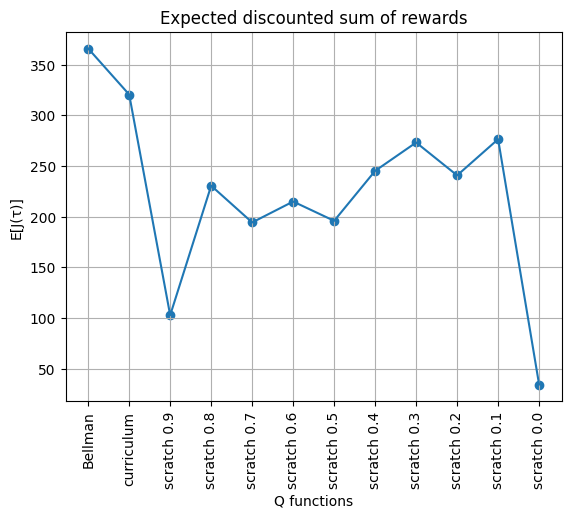

In [11]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_J'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)




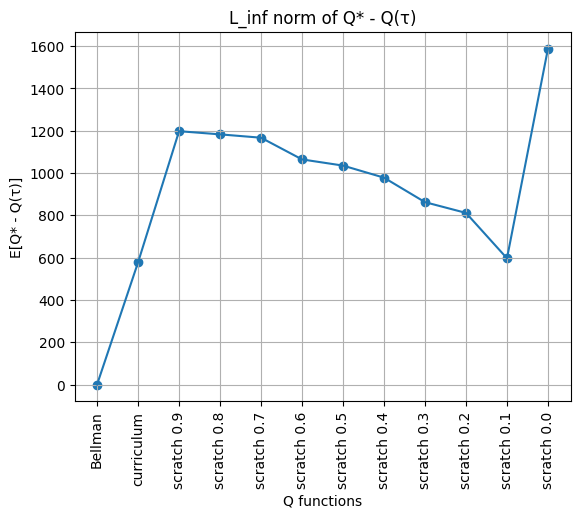

In [12]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_delta_q'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[Q* - Q(τ)]")
plt.title("L_inf norm of Q* - Q(τ)")
plt.grid(visible=True)

In [13]:
print(len(agg_res[0]['J']))

6


In [14]:
V_star = get_value_function(Q_star)
print(V_star)

A = get_policy_advantage_function(Q_star, False)
print(A)

[ 70.06   96.009 140.217 206.885 305.732 451.916 668.02  987.469]
[[-1.768e+00  2.379e-01]
 [-3.295e+01  1.563e-13]
 [-5.381e+01  0.000e+00]
 [-8.069e+01  0.000e+00]
 [-1.195e+02  0.000e+00]
 [-1.768e+02  0.000e+00]
 [-2.613e+02  0.000e+00]
 [-3.863e+02  0.000e+00]]


In [15]:
A = get_model_advantage_function(tmdp.P_mat, tmdp.reward, tmdp.gamma, Q_star, True)
print(tmdp.P_mat)
pi_prime = np.array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])
A_pi_pi_prime = get_relative_policy_advantage_function(Q_star, pi_prime)
print(A_pi_pi_prime)

[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.7 0.3 0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.6 0.3 0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.6 0.3 0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.6 0.3 0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.6 0.3 0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.6 0.3 0. ]
 [0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.6 0.3]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.7 0.3]]
[ -2.006 -32.954 -53.809   0.      0.      0.      0.      0.   ]


In [16]:
print(len(intermediate_results.keys()))


11


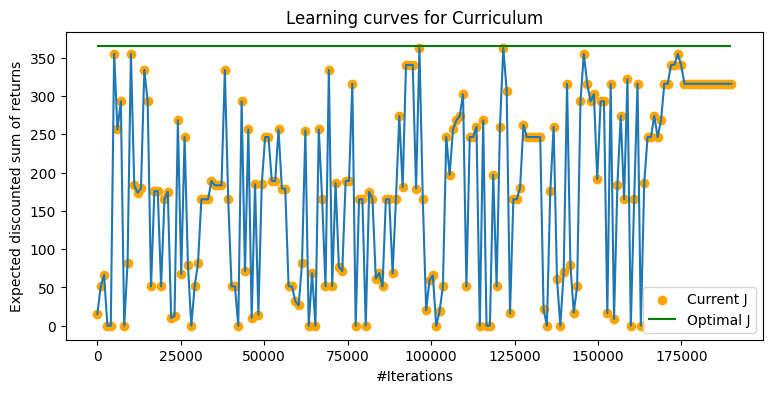

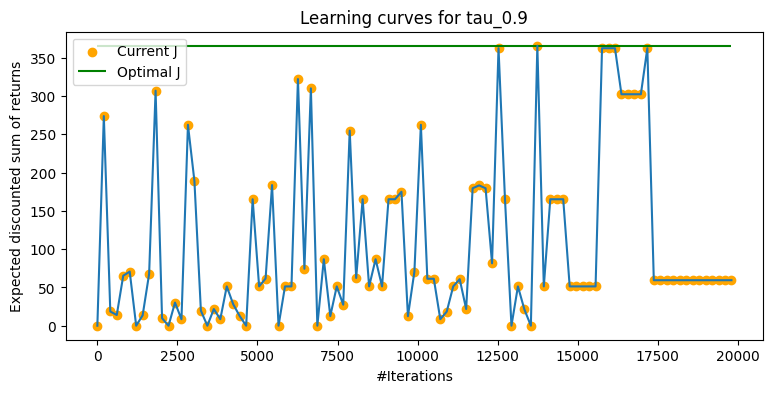

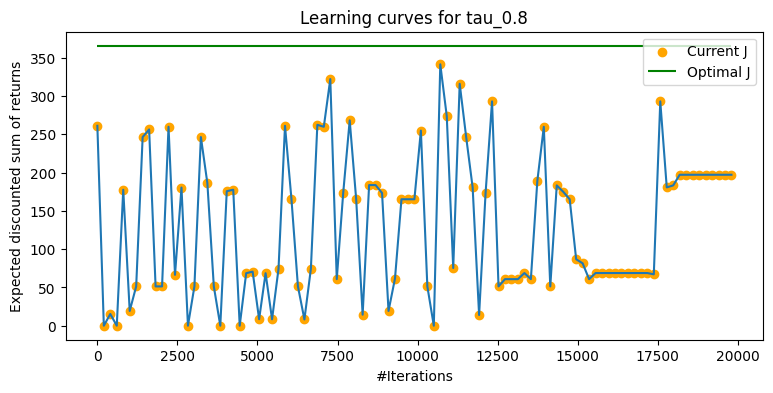

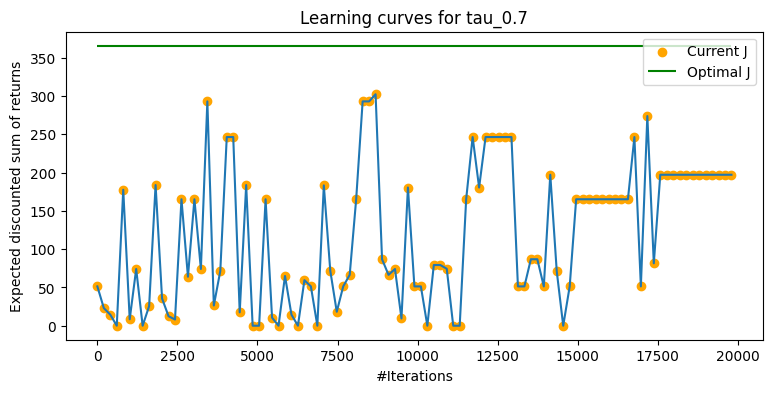

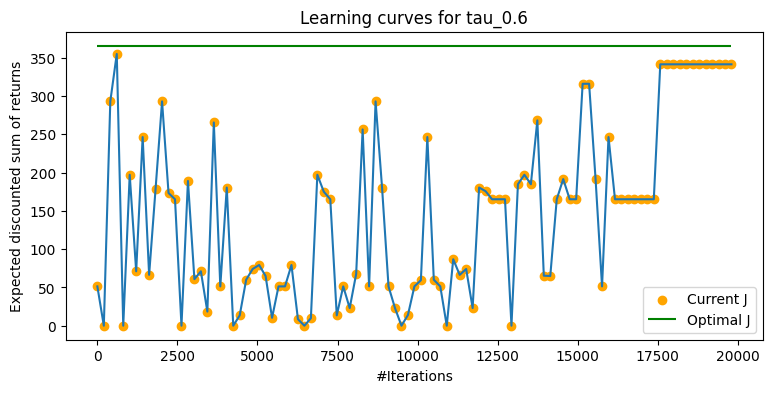

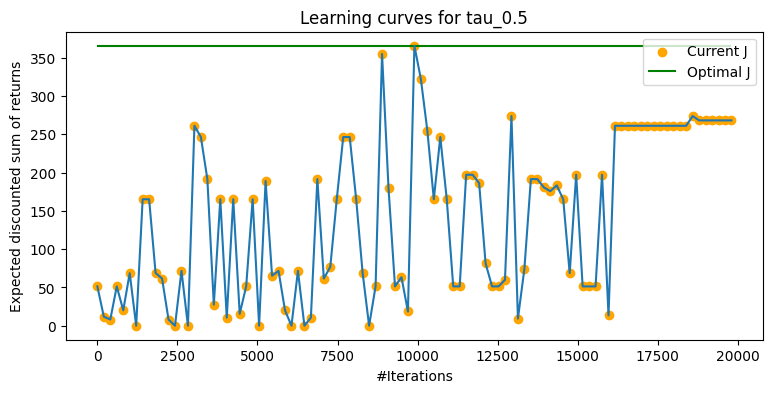

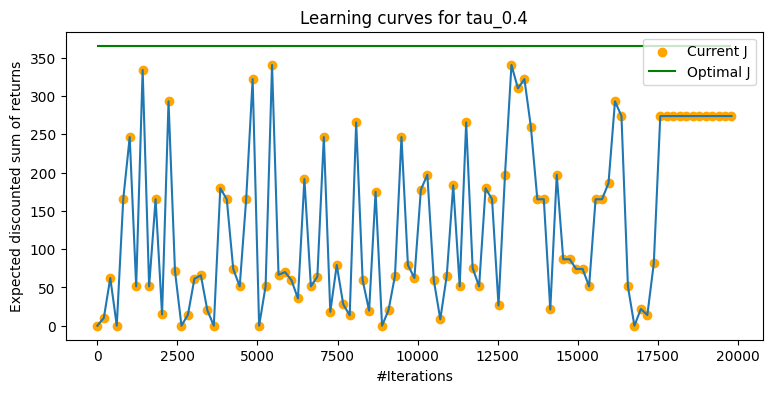

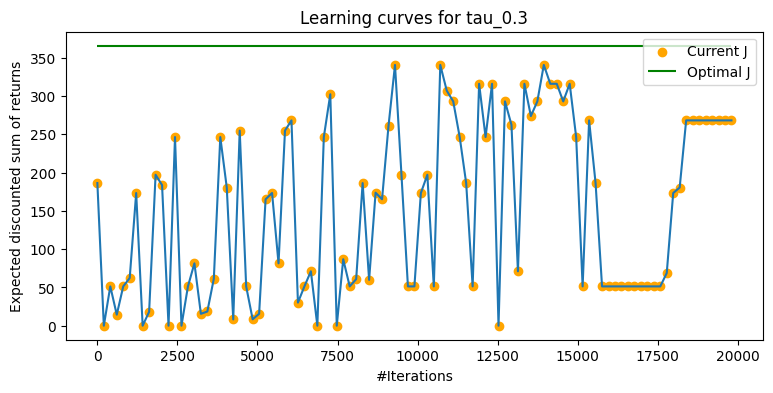

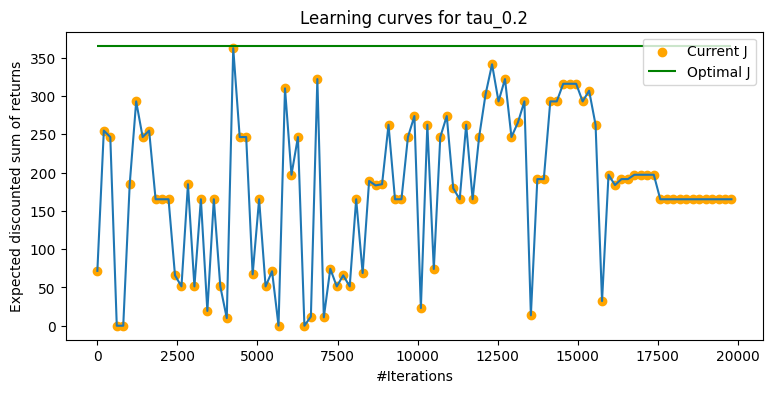

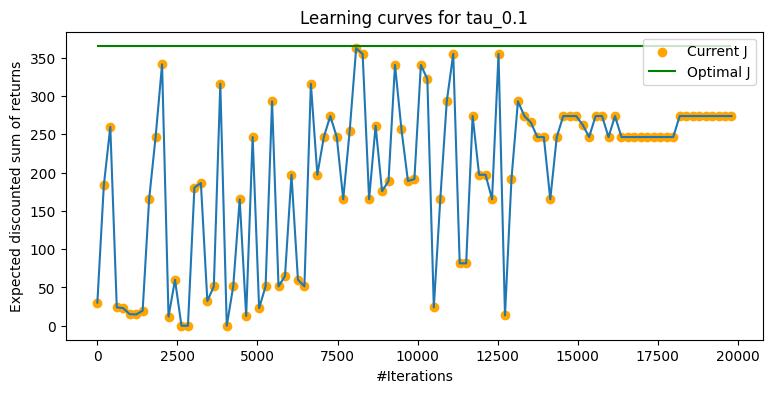

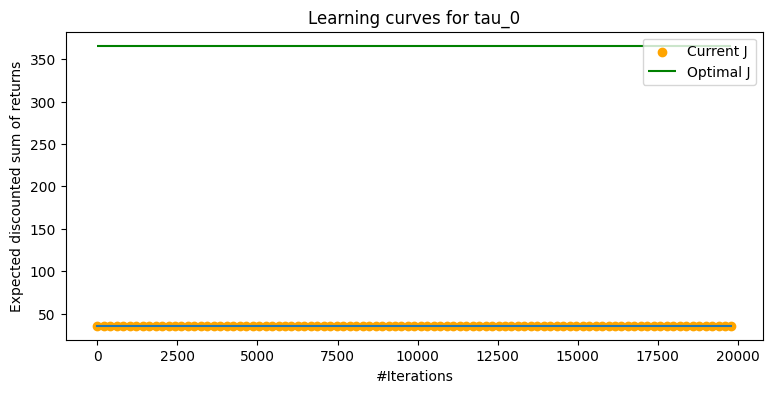

In [19]:
for i, key in enumerate(intermediate_results.keys()):
    status_step = 200
    if i == 0:
        status_step = 1000
    xmax = len(intermediate_results[key])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]))
    y = intermediate_results[key]
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.legend()
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))